<a href="https://colab.research.google.com/github/SRET-College/Sem-5-RL-Lab/blob/main/RL_LAB_EXPT_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Explore the observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action Space: Discrete(2)


In [3]:
def mc_prediction(env, num_episodes, policy):
    """
    Monte Carlo prediction to estimate state-action values.

    Args:
        env: The Gymnasium environment.
        num_episodes: The number of episodes to simulate.
        policy: A function that takes a state and returns an action.

    Returns:
        A dictionary containing the estimated value for each state.
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    estimated_values = defaultdict(float)

    for i in range(num_episodes):
        episode = []
        state, info = env.reset()
        terminated = False
        truncated = False

        while not terminated and not truncated:
            action = policy(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # Go through the episode and update returns
        states_in_episode = set([x[0] for x in episode])
        for state in states_in_episode:
            first_occurrence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            G = sum([x[2] for x in episode[first_occurrence_idx:]])
            returns_sum[state] += G
            returns_count[state] += 1.0
            estimated_values[state] = returns_sum[state] / returns_count[state]

    return estimated_values

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, epsilon):
    """
    Monte Carlo control with epsilon-greedy policy to find the optimal policy.

    Args:
        env: The Gymnasium environment.
        num_episodes: The number of episodes to simulate.
        epsilon: The epsilon value for the epsilon-greedy policy.

    Returns:
        A tuple containing the optimal Q-values and the optimal policy.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    optimal_policy = {}
    optimal_q_values = {}

    for i in range(num_episodes):
        episode = []
        state, info = env.reset()
        terminated = False
        truncated = False

        # Generate an episode using epsilon-greedy policy
        while not terminated and not truncated:
            # Epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit

            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # Update Q-values
        states_and_actions_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in states_and_actions_in_episode:
            first_occurrence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] for x in episode[first_occurrence_idx:]])
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

        # Update optimal policy and Q-values
        for state, action_values in Q.items():
          optimal_policy[state] = np.argmax(action_values)
          optimal_q_values[state, np.argmax(action_values)] = np.max(action_values)


    return optimal_q_values, optimal_policy

In [5]:
# Define parameters
num_episodes_control = 5000  # Number of episodes for control
epsilon_value = 0.1  # Epsilon for epsilon-greedy policy

# Run Monte Carlo control
optimal_q_values, optimal_policy = mc_control_epsilon_greedy(env, num_episodes_control, epsilon_value)

# Print some of the learned optimal policy
print("Learned Optimal Policy (some examples):")
for state, action in list(optimal_policy.items())[:10]:
    print(f"State: {state}, Optimal Action: {action} (0: Stick, 1: Hit)")

# Print some of the learned optimal Q-values
print("\nLearned Optimal Q-values (some examples):")
for state_action, q_value in list(optimal_q_values.items())[:10]:
    print(f"State-Action: {state_action}, Q-value: {q_value}")

Learned Optimal Policy (some examples):
State: (20, 10, 0), Optimal Action: 0 (0: Stick, 1: Hit)
State: (10, 10, 0), Optimal Action: 1 (0: Stick, 1: Hit)
State: (6, 10, 0), Optimal Action: 1 (0: Stick, 1: Hit)
State: (14, 10, 1), Optimal Action: 1 (0: Stick, 1: Hit)
State: (18, 7, 0), Optimal Action: 0 (0: Stick, 1: Hit)
State: (20, 7, 0), Optimal Action: 0 (0: Stick, 1: Hit)
State: (14, 2, 1), Optimal Action: 0 (0: Stick, 1: Hit)
State: (13, 5, 0), Optimal Action: 0 (0: Stick, 1: Hit)
State: (19, 5, 0), Optimal Action: 0 (0: Stick, 1: Hit)
State: (13, 10, 0), Optimal Action: 1 (0: Stick, 1: Hit)

Learned Optimal Q-values (some examples):
State-Action: ((20, 10, 0), np.int64(0)), Q-value: 0.5027322404371585
State-Action: ((10, 10, 0), np.int64(1)), Q-value: -0.056338028169014086
State-Action: ((6, 10, 0), np.int64(0)), Q-value: -0.68
State-Action: ((14, 10, 1), np.int64(1)), Q-value: -0.391304347826087
State-Action: ((18, 7, 0), np.int64(0)), Q-value: 0.4482758620689655
State-Action: (

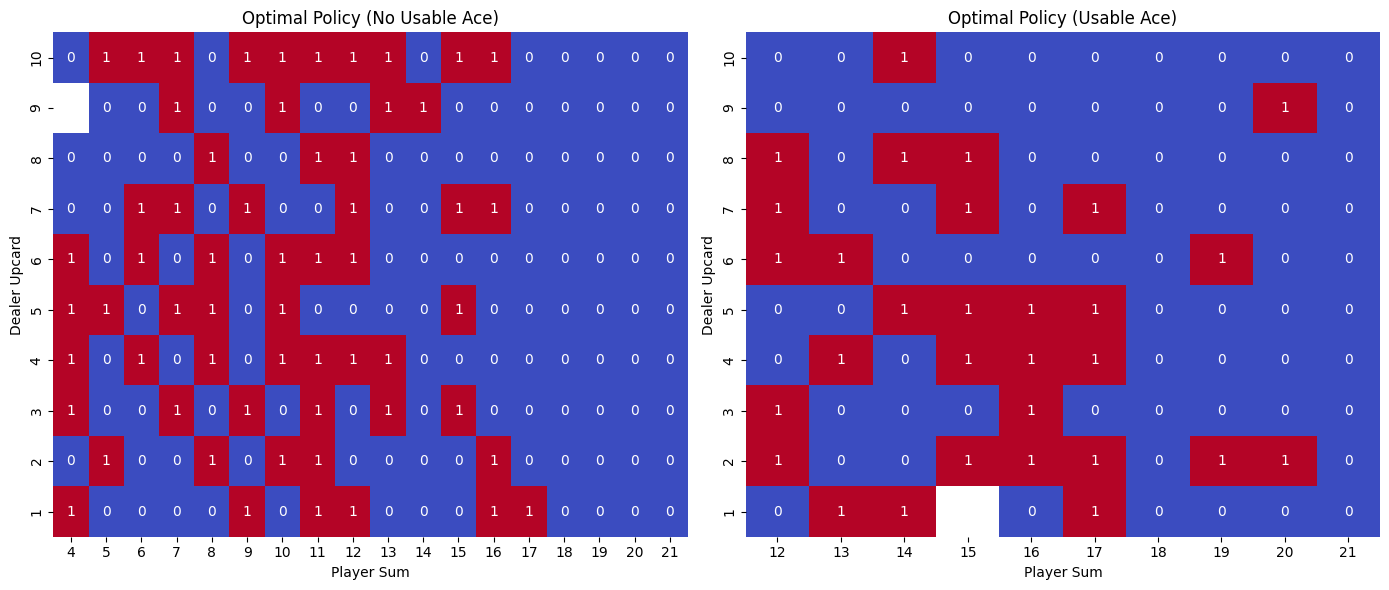

In [6]:
# Prepare data for visualization
# Separate policies for hands with and without a usable ace
policy_no_ace = {k: v for k, v in optimal_policy.items() if not k[2]}
policy_with_ace = {k: v for k, v in optimal_policy.items() if k[2]}

# Create DataFrames for easier plotting
policy_df_no_ace = pd.DataFrame([
    {'Player Sum': state[0], 'Dealer Upcard': state[1], 'Optimal Action': action}
    for state, action in policy_no_ace.items()
])

policy_df_with_ace = pd.DataFrame([
    {'Player Sum': state[0], 'Dealer Upcard': state[1], 'Optimal Action': action}
    for state, action in policy_with_ace.items()
])

# Pivot tables for heatmap
policy_pivot_no_ace = policy_df_no_ace.pivot_table(
    index='Dealer Upcard', columns='Player Sum', values='Optimal Action'
).sort_index(ascending=False)

policy_pivot_with_ace = policy_df_with_ace.pivot_table(
    index='Dealer Upcard', columns='Player Sum', values='Optimal Action'
).sort_index(ascending=False)

# Plotting the optimal policy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(policy_pivot_no_ace, annot=True, fmt=".0f", cmap="coolwarm", cbar=False)
plt.title('Optimal Policy (No Usable Ace)')
plt.xlabel('Player Sum')
plt.ylabel('Dealer Upcard')

plt.subplot(1, 2, 2)
sns.heatmap(policy_pivot_with_ace, annot=True, fmt=".0f", cmap="coolwarm", cbar=False)
plt.title('Optimal Policy (Usable Ace)')
plt.xlabel('Player Sum')
plt.ylabel('Dealer Upcard')

plt.tight_layout()
plt.show()